# Assessing suitability of a location for thermal curtains and light shades to increase crop growth

## Introduction
Plants do not grow effectively and get can get damaged in high temperatures and too much sun. Conversely dull, cool days inhibit photosynthesis and plants do not grow effeciently, if temperatures drop too low grow may be damaged and leaves dropped impacting growth for many weeks.  Many greenhouse growers choose to whitewash the glass to reflect the heat and dissipate the light. However, adding white wash is time consuming, so the wash is only applied once per season, meaning if a cooler or cloudier spell of weather occurs the plants can't grow optimally. An increasingly popular alternative is fitting greenhouses with shading curtains which are easier to remove on cloudier days and can been drawn at night to retain heat. Through this project we investigate areas of xxxxxxxxxxxxxxxx to see white washing and thermal curtains are not efficient due to frequent temperature variations.

The meteostat platform has been used to access the weather data for the basis of this project [(1)](https://dev.meteostat.net/). Due to the amount of data it has been stored in a MySQL database and analysed using charts and predictions made using SciKitLearn.


# Plant shading techniques
Each of the different plant shading techniques have different characteristics and efficiencies. White washing requires good knowledge on when to white wash and remove it, but is very cheap, thermal curtains are easier to use, but are more expensive to buy.

## White washing
White washing is best applied to green houses when the days are consistently above 25 degrees and removed at the end of the season. The white washing provides limited thermal properties at night and hence only day time highs are of importance. The standard white washing protocol reduces daytime temperatures by 6.8% on sunny days.

In [1]:
whitewash = 6.8/100

### Thermal curtains
Thermal curtains can easily be pulled and retracted in line with local conditions. A shade rated for 50% shading gives the most similar effects in daytime to white washing and this reduced the daytime temperatures by 6.9% on sunny days and maintained over night temperatures by 2.1%.

In [112]:
curtains_day = 1-(6.9/100)
curtains_night = 1+(4.1/100)


1.041


### The test plants
"Head lettuce is the most important salad vegetable gown in the United States" [(2)](https://content.ces.ncsu.edu/lettuce). The optimum growing temperature for head lettuce is 15-18°C. At 20-26°C the plants start to flower and produce seed and need replacing and temperatures below 0°C will kill the plants.


In [82]:
lettuce_min = 0
lettuce_max = 20
lettuce_range1 = 15
lettuce_range2 = 20

Tomatoes are grown across the world and are an important staple in many cuisines. To increase their range and season many are grown in greenhouses. The optimal conditions for growth are 21-27°C with temperatures not dropping below 16°C or exceeding 29°C [(3)](https://drygair.com/blog/what-are-the-ideal-conditions-for-greenhouse-tomatoes/).

In [13]:
tomato_min = 16
tomato_max = 29
tomato_range1 = 21
tomato_range2 = 27

## Import needed tools

In [107]:
# Create the mySQL database
import mysql.connector as msql

# Import the data and unzip it
import requests
import gzip
from io import BytesIO
import json

# Create the dataframe and manipulate it
import pandas as pd
import datetime as dt

# Plot the data
import matplotlib.pyplot as plt
import seaborn as sns

# Work with decimals
from decimal import Decimal

# Create a database to store the data
Due to the large amounts of data needed for this analysis. A MySQL database needs to be created. MySQL offers the ability to store very large amounts of data in a structured and easily accessible way, where the data is persistent. 

To create the database we first set the connection parameters for the database and create the cursor to enable the connection for making SQL queries.


In [2]:
# Set the parameters for the connection
db = msql.connect(host='localhost', user='root',password='')

# Create the cursor
cursor = db.cursor()

# Execute SQL query
cursor.execute('CREATE DATABASE weather')
print('The database "weather" has been created')

# Close the connection
cursor.close()
db.close()

The database "weather" has been created


## Create a table for the weather station data
Within the database a table needs to be created for each of the data sources. The first table will hold a list of the weather stations [(4)](https://dev.meteostat.net/bulk/stations.html#endpoints). The data about all the weather stations is available at: https://bulk.meteostat.net/v2/stations/lite.json.gz. It is compressed using `gzip` so the file needs to be decompressed before creating the dataframe and inserting the information into the database.

In [3]:
try:
    # Connect to MySQL
    con = msql.connect(host='localhost', database='weather', user='root', password='')

    if con.is_connected():
        cursor = con.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"You're connected to database: {record}")
        
        # Drop the table if it exists
        cursor.execute('DROP TABLE IF EXISTS stations_data')
        print('Creating table....')
        
        # Create the table
        sql = """CREATE TABLE stations_data 
            (id VARCHAR(10) PRIMARY KEY, 
            name JSON, 
            country CHAR(2), 
            region VARCHAR(10), 
            national_id VARCHAR(10), 
            wmo_id VARCHAR(10), 
            icao_id VARCHAR(10), 
            iata_id VARCHAR(25), 
            latitude DECIMAL(9,6), 
            longitude DECIMAL(9,6), 
            elevation INT, 
            timezone VARCHAR(25),
            history JSON, 
            hourly_start DATE, 
            hourly_end DATE, 
            daily_start DATE,
            daily_end DATE,
            monthly_start YEAR,
            monthly_end YEAR,
            normals_start YEAR,
            normals_end YEAR
)"""
        cursor.execute(sql)
        print("Table is created....")

except msql.Error as err:
    print(err.msg)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

You're connected to database: ('weather',)
Creating table....
Table is created....


## Read in the weather station data

Then the weather stations table needs to be populated.

In [4]:
# File name and location
url = "https://bulk.meteostat.net/v2/stations/full.json.gz"
file_name = "full.json.gz"

# Download the file
response = requests.get(url, stream=True)
with open(file_name, 'wb') as f:
    f.write(response.content)

# Decompress the file
with gzip.open(file_name, 'rt', encoding='utf-8') as gz_file:
    stations_file = json.load(gz_file)

# Connect to the MySQL Database
try:
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        print("Connected to the database.")

        # Prepare SQL statement for data insertion
        sql_insert = """
            INSERT INTO stations_data (
                id, name, country, region, national_id, wmo_id, icao_id, iata_id,
                latitude, longitude, elevation, timezone, history,
                hourly_start, hourly_end, daily_start, daily_end,
                monthly_start, monthly_end, normals_start, normals_end
            ) VALUES (
                %(id)s, %(name)s, %(country)s, %(region)s, %(national_id)s, %(wmo_id)s, %(icao_id)s, %(iata_id)s,
                %(latitude)s, %(longitude)s, %(elevation)s, %(timezone)s, %(history)s,
                %(hourly_start)s, %(hourly_end)s, %(daily_start)s, %(daily_end)s,
                %(monthly_start)s, %(monthly_end)s, %(normals_start)s, %(normals_end)s
            )
        """

        # Insert Data into MySQL Table
        for station in stations_file:
            data = {
                'id': station.get('id'),
                'name': json.dumps(station.get('name', {})),  # Convert dictionary to JSON string
                'country': station.get('country'),
                'region': station.get('region'),
                'national_id': station.get('national'),
                'wmo_id': station.get('wmo'),
                'icao_id': station.get('icao'),
                'iata_id': station.get('iata'),
                'latitude': station.get('latitude'),
                'longitude': station.get('longitude'),
                'elevation': station.get('elevation'),
                'timezone': station.get('timezone'),
                'history': json.dumps(station.get('history', [])),  # Convert list to JSON string
                'hourly_start': station.get('inventory', {}).get('hourly', {}).get('start'),
                'hourly_end': station.get('inventory', {}).get('hourly', {}).get('end'),
                'daily_start': station.get('inventory', {}).get('daily', {}).get('start'),
                'daily_end': station.get('inventory', {}).get('daily', {}).get('end'),
                'monthly_start': station.get('inventory', {}).get('monthly', {}).get('start'),
                'monthly_end': station.get('inventory', {}).get('monthly', {}).get('end'),
                'normals_start': station.get('inventory', {}).get('normals', {}).get('start'),
                'normals_end': station.get('inventory', {}).get('normals', {}).get('end'),
            }
            cursor.execute(sql_insert, data)

        # Commit the transaction
        con.commit()
        print("Data inserted successfully.")

# Print details if an error occurs
except msql.Error as err:
    print(f"Error: {err}")

# Close the connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()
        print("MySQL connection is closed.")

Connected to the database.
Data inserted successfully.
MySQL connection is closed.


## Select the country of interest


In [5]:
con = msql.connect(host='localhost', database='weather', user='root', password='')

cursor = con.cursor()

sql = "SELECT DISTINCT country FROM stations_data"

cursor.execute(sql)
results = cursor.fetchall()
print("The country codes are explained at: https://www.iban.com/country-codes")
print(f"The countries available are:")
for row in results:
    print(row)

cursor.close()
con.close()

The country codes are explained at: https://www.iban.com/country-codes
The countries available are:
('CA',)
('NO',)
('SE',)
('FI',)
('DE',)
('GB',)
('IM',)
('IE',)
('IS',)
('GL',)
('US',)
('FO',)
('DK',)
('NL',)
('XA',)
('BE',)
('FR',)
('LU',)
('CH',)
('CN',)
('LI',)
('PT',)
('ES',)
('GI',)
('CV',)
('AU',)
('AT',)
('CZ',)
('SK',)
('PL',)
('HU',)
('RS',)
('SI',)
('HR',)
('XK',)
('BA',)
('CS',)
('MK',)
('AL',)
('RO',)
('BG',)
('IT',)
('MT',)
('GR',)
('TR',)
('CY',)
('RU',)
('EE',)
('LV',)
('LT',)
('BY',)
('KZ',)
('UA',)
('MD',)
('KG',)
('GE',)
('AZ',)
('AM',)
('UZ',)
('TM',)
('TJ',)
('SY',)
('LB',)
('IL',)
('PS',)
('JO',)
('SA',)
('QA',)
('KW',)
('IQ',)
('IR',)
('AF',)
('BH',)
('AE',)
('OM',)
('YE',)
('PK',)
('BD',)
('IN',)
('NP',)
('LK',)
('MV',)
('MN',)
('HK',)
('MO',)
('TW',)
('KP',)
('KR',)
('JP',)
('MM',)
('TH',)
('MY',)
('MX',)
('SG',)
('VN',)
('LA',)
('KH',)
('EH',)
('MA',)
('DZ',)
('TN',)
('LY',)
('NE',)
('ML',)
('MR',)
('SN',)
('GM',)
('GW',)
('GN',)
('SL',)
('SH',)
('AQ',)
('ST

## Prompt user to input the country of interest
The user should be prompted to select the country of interest. 


In [6]:
print("The country codes are explained at: https://www.iban.com/country-codes")
chosencountry = input(str("Enter the country of interest, using the two digit code: "))


The country codes are explained at: https://www.iban.com/country-codes


In [8]:
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        # Get user to input the country code
        chosencountry = input(str("Enter the country of interest, using the two digit code: ")).strip().upper()
        
        # Check the user input is valid
        if len(chosencountry) != 2:
            print("Invalid country code. Please enter a valid 2- character country code.")
        else: # Exectute the SQL query
            query = sql = "SELECT DISTINCT region FROM stations_data WHERE country = %s"
            cursor.execute(query, (chosencountry,)) 
            
            # Fetch and display the results
            results = cursor.fetchall()
            if results:
                print(f"The regions within {chosencountry} available are:")
                for row in results:
                    print(row)
            else:
                print(f"No regions found for country code: {chosencountry}")
                
except msql.Error as err:
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()


The regions within CA available are:
('AB',)
('MB',)
('BC',)
('SK',)
('NU',)
('ON',)
('YT',)
('QC',)
('NS',)
('NL',)
('NT',)
('PE',)
('NB',)
('SD',)
('NF',)


## Select the weather stations in the country and region of interest

In [28]:
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        # Get user to input the region code
        chosenregion = input(str("Enter the region of interest, using the two digit code: ")).strip().upper()
        
        # Check the user input is valid
        if len(chosenregion) != 2:
            print("Invalid region code. Please enter a valid 2- character region code.")
        else: # Execute the SQL query
            query ="SELECT id FROM stations_data WHERE country = %s AND region = %s AND daily_start IS NOT NULL"
            cursor.execute(query, (chosencountry, chosenregion,)) 
            
            # Fetch and display the results
            station_ids = [str(row[0]) for row in cursor.fetchall()]
            if results:
                print(f"The stations within {chosenregion} are:")
                for row in station_ids:
                    print(row)
            else:
                print(f"No stations found for region code: {chosenregion} in country code: {chosencountry}")
                
except msql.Error as err:
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

The stations within ON are:
0CNUO
0CO7B
0FV1F
0FV2W
10RIK
128HL
13178
17CKT
1D16Y
1J1PJ
1JWST
1Y8OJ
21O3U
2FXL8
2W8UZ
2XUGG
3EADS
3S56J
44BUQ
4DA9G
4DUJO
5MKGL
5RUZT
65YVF
6N2T2
71063
71099
71151
71161
71171
71172
71193
71260
71261
71262
71263
71265
71270
71272
71281
71282
71290
71291
71292
71294
71295
71296
71297
71298
71299
71300
71301
71303
71307
71309
71314
71352
71368
71369
71399
71430
71431
71432
71433
71434
71435
71436
71437
71438
71439
71460
71462
71463
71464
71465
71466
71468
71508
71527
71534
71538
71559
71573
71581
71582
71620
71621
71623
71624
71625
71628
71629
71630
71631
71632
71633
71639
71642
71655
71660
71667
71672
71694
71697
71704
71730
71731
71733
71735
71738
71739
71747
71749
71750
71751
71752
71755
71767
71820
71831
71832
71834
71835
71836
71841
71842
71844
71845
71846
71850
71854
71956
71962
75BU2
7FGUJ
7L5OL
7PXZ6
7Q717
7ZTNB
82JYP
86WK3
8HNVP
8IOCM
8PJPB
8TSI8
8WZUG
93RHE
9GNQU
9H92X
9HC7K
9K6D9
9M4XD
9W5OW
ADBC1
AE2A1
ATA0X
BI2NY
CNR66
CTAL0
CTCK0
CTGT0
CTWN0


## Create a table for the weather data for each region

### Create table for the weather data for the chosen country and region

In [45]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to MySQL
    con = msql.connect(host='localhost', database='weather', user='root', password='')

    if con.is_connected():
        cursor = con.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"You're connected to database: {record}")
        
        # Drop the table if it exists
        drop_query = f"DROP TABLE IF EXISTS `{table_name}`"
        cursor.execute(drop_query)
        print(f"Table '{table_name}' dropped if it existed.")
        
        # Create the table
        create_query = f"""
        CREATE TABLE `{table_name}` (
            id VARCHAR(10) PRIMARY KEY, 
            station_id VARCHAR(10),
            date DATE,
            avg_temp DECIMAL(5,1), 
            min_temp DECIMAL(5,1),
            max_temp DECIMAL(5,1),
            month INT,
            year YEAR
        )
        """
        cursor.execute(create_query)
        print(f"Table '{table_name}' is created successfully.")

except msql.Error as err:
    print(err.msg)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

You're connected to database: ('weather',)
Table 'ca_on_data' dropped if it existed.
Table 'ca_on_data' is created successfully.


Now the table needs to be populated with the data for each of the weather stations in the chosen country and region.

In [54]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

# Connect to the MySQL Database
try:
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        print("Connected to the database.")

        # Insert Data into MySQL Table
        for station in station_ids:
            print(f"Processing station: {station}")

            # Download the file
            url = f"https://bulk.meteostat.net/v2/daily/{station}.csv.gz"
            response = requests.get(url)
            response.raise_for_status()  # Ensure the request was successful

            if response.status_code == 200:
                # Read the CSV file into a DataFrame
                stations_data = gzip.GzipFile(fileobj=BytesIO(response.content))
                df = pd.read_csv(stations_data, usecols=[0, 1, 2, 3], names=['date', 'avg_temp', 'min_temp', 'max_temp'], parse_dates=['date'])
                df.dropna(inplace=True)

                # Add a station ID column
                df['station_id'] = station

                # Add month and year columns
                df["year"] = df["date"].dt.year
                df["month"] = df["date"].dt.month

                counter = 0
                for _, row in df.iterrows():
                    # Create a unique ID for each row
                    id = f"{row['station_id']}_{counter}"
                    
                    # Prepare SQL statement for data insertion
                    sql_insert = f"""
            INSERT INTO `{table_name}` (id, station_id, date, avg_temp, min_temp, max_temp, month, year) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """
                    # Insert data into MySQL table
                    cursor.execute(sql_insert,(
                        id,
                        row["station_id"],
                        row["date"].date(),
                        row.get("avg_temp", None),
                        row.get("min_temp", None),
                        row.get("max_temp", None),
                        row["month"],
                        row["year"],
                    ))
                    counter += 1
                con.commit()
                print(f"Data from station {station} inserted successfully.")
            else:
                print(f"Failed to download data for station: {station}")
except msql.Error as err:
    print(f"Error: {err}")

# Close the connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()
        print("MySQL connection is closed.")






Connected to the database.
Processing station: 0CNUO
Data from station 0CNUO inserted successfully.
Processing station: 0CO7B
Data from station 0CO7B inserted successfully.
Processing station: 0FV1F
Data from station 0FV1F inserted successfully.
Processing station: 0FV2W
Data from station 0FV2W inserted successfully.
Processing station: 10RIK
Data from station 10RIK inserted successfully.
Processing station: 128HL
Data from station 128HL inserted successfully.
Processing station: 13178
Data from station 13178 inserted successfully.
Processing station: 17CKT
Data from station 17CKT inserted successfully.
Processing station: 1D16Y
Data from station 1D16Y inserted successfully.
Processing station: 1J1PJ
Data from station 1J1PJ inserted successfully.
Processing station: 1JWST
Data from station 1JWST inserted successfully.
Processing station: 1Y8OJ
Data from station 1Y8OJ inserted successfully.
Processing station: 21O3U
Data from station 21O3U inserted successfully.
Processing station: 2FXL

# Analysing the weather data
https://dev.meteostat.net/bulk/daily.html#endpoints

## Average the data by month

First get the user to select a station id


Station 10RIK is available.


Use this choice to extract the daily average temperature data for the station of interest from the database.

In [117]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        #Request user to input the station ID
        chosenstation = input(str("Enter the station ID of interest: ").strip().upper())
        
        if chosenstation in station_ids:
            print(f"Station {chosenstation} is available.")
        else:
            print(f"Please choose from one of the following station IDs: {station_ids}")
        
        # Execute the SQL query
        query =f"SELECT date, avg_temp, min_temp, max_temp, month, year FROM `{table_name}` WHERE station_id = %s"
        cursor.execute(query, (chosenstation,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df= pd.DataFrame(rows)
        df.columns=['date', 'avg_temp', 'min_temp', 'max_temp', 'month', 'year']
        
        # Print the first 5 rows
        print(df.head(5))

except msql.Error as err: 
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

Station 10RIK is available.
         date avg_temp min_temp max_temp  month  year
0  2000-01-01     -2.5    -11.0      6.0      1  2000
1  2000-01-02      5.0     -2.0     12.0      1  2000
2  2000-01-03     -0.3     -2.0      1.5      1  2000
3  2000-01-04      4.5     -2.0     11.0      1  2000
4  2000-01-05     -8.8    -11.5     -6.0      1  2000


### Plot the data for the average temperature


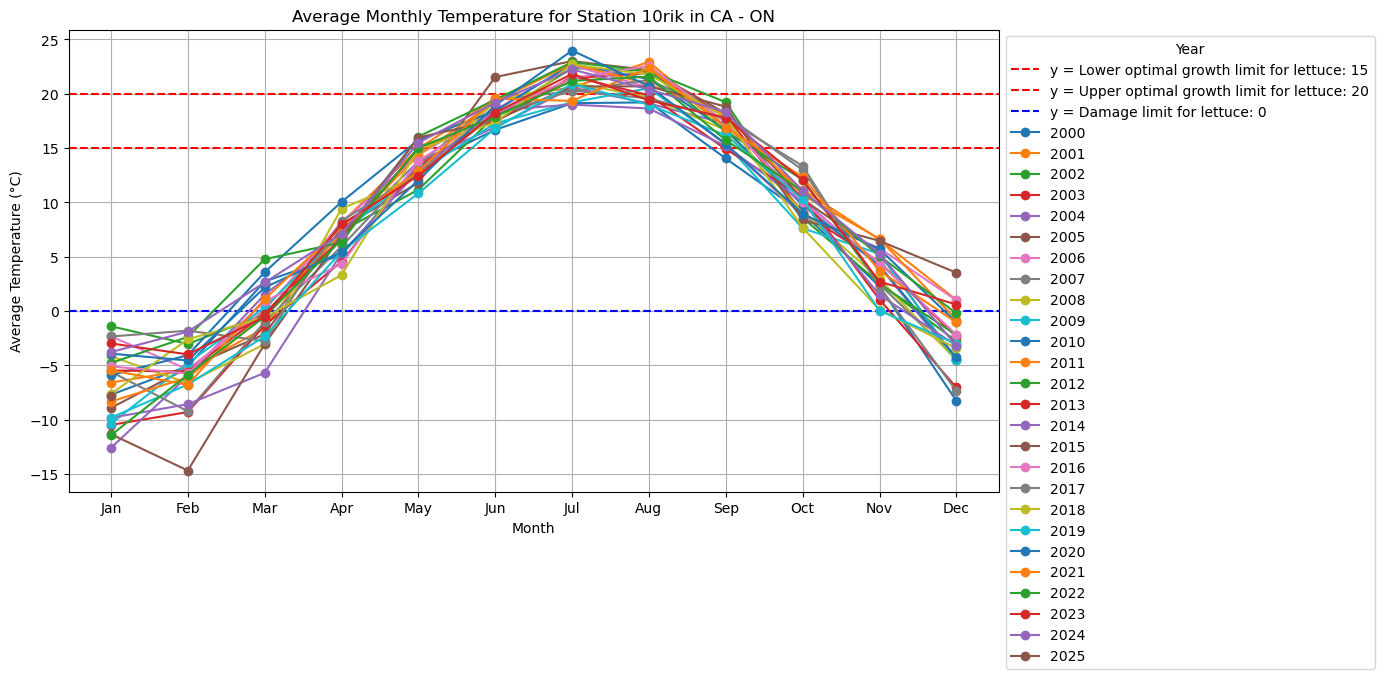

In [93]:
# Group by year and month, then calculate the average temperature for each month
monthly_avg = df.groupby(["year", "month"])["avg_temp"].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
years = monthly_avg["year"].unique()

# Draw a horizontal line at y_value
plt.axhline(y=lettuce_range1, color='r', linestyle='--', label=f'y = Lower optimal growth limit for lettuce: {lettuce_range1}')
plt.axhline(y=lettuce_range2, color='r', linestyle='--', label=f'y = Upper optimal growth limit for lettuce: {lettuce_range2}')
plt.axhline(y=lettuce_min, color='b', linestyle='--', label=f'y = Damage limit for lettuce: {lettuce_min}')
for year in years:
    year_data = monthly_avg[monthly_avg["year"] == year]
    plt.plot(year_data["month"], year_data["avg_temp"], marker="o", label=str(year))


plt.title(f"Average Monthly Temperature for Station {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


## Average minimum temperatures

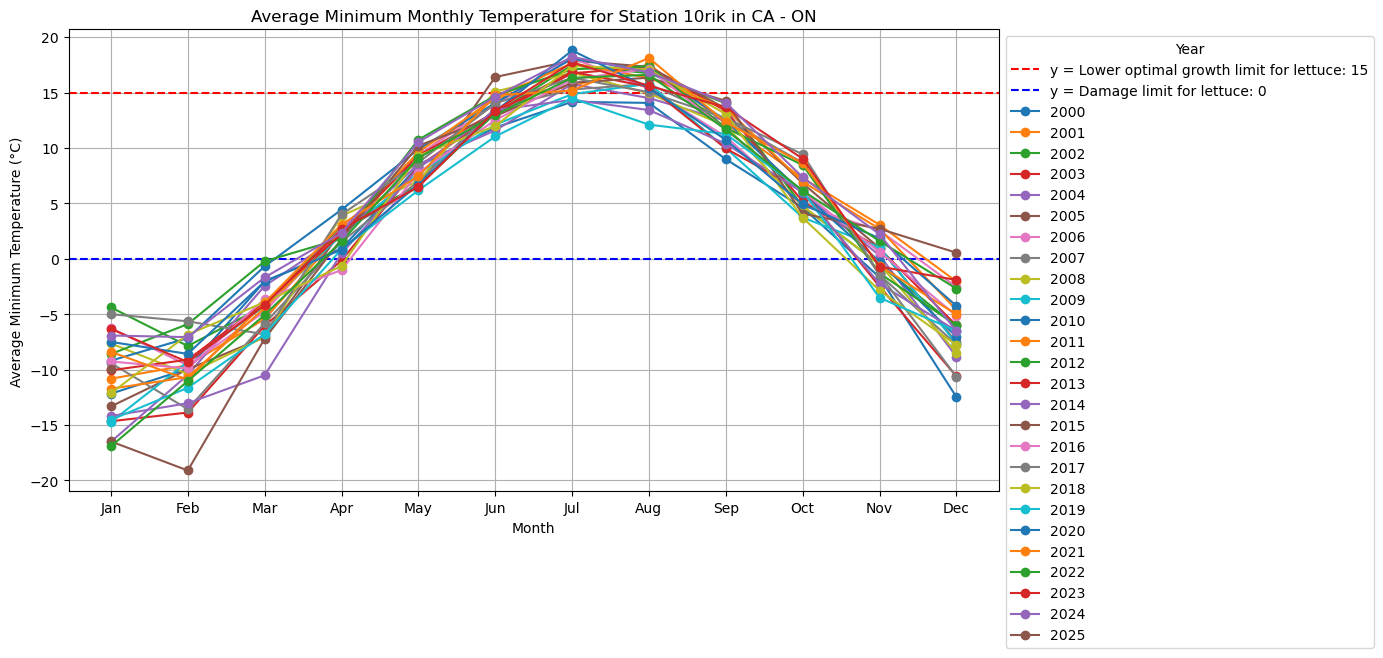

In [98]:
# Group by year and month, then calculate the minimum average temperature for each month
min_monthly_avg = df.groupby(["year", "month"])["min_temp"].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
years = min_monthly_avg["year"].unique()

# Draw a horizontal line at y_value
plt.axhline(y=lettuce_range1, color='r', linestyle='--', label=f'y = Lower optimal growth limit for lettuce: {lettuce_range1}')
plt.axhline(y=lettuce_min, color='b', linestyle='--', label=f'y = Damage limit for lettuce: {lettuce_min}')
for year in years:
    year_data = monthly_avg[monthly_avg["year"] == year]
    plt.plot(year_data["month"], year_data["min_temp"], marker="o", label=str(year))


plt.title(f"Average Minimum Monthly Temperature for Station {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Average Minimum Temperature (°C)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Analying the impact of thermal curtains on the minimum temperatures




In [101]:
# Calculate the number of cold days per month and year
cold_days_per_month = (
    df[df["min_temp"] < lettuce_range1]  # Filter for days below the threshold
    .groupby(["year", "month"])          # Group by year and month
    .size()                              # Count the number of days per group
    .reset_index(name="cold_days_count") # Reset the index and name the count column
)

# Print the results
print(cold_days_per_month)



     year  month  cold_days_count
0    2000      1               31
1    2000      2               29
2    2000      3               31
3    2000      4               30
4    2000      5               31
..    ...    ...              ...
296  2024      9               15
297  2024     10               31
298  2024     11               30
299  2024     12               27
300  2025      1                9

[301 rows x 3 columns]


### Calculate the impact of the thermal curtains



In [113]:
lettuce_range1 = Decimal(lettuce_range1)
thermal_curtains = Decimal(curtains_night)
cold_days = df[df["min_temp"] < lettuce_range1]
df["temp_curtains"] = df["min_temp"]*thermal_curtains

print(df.head())

         date avg_temp min_temp max_temp  month  year  \
0  2000-01-01     -2.5    -11.0      6.0      1  2000   
1  2000-01-02      5.0     -2.0     12.0      1  2000   
2  2000-01-03     -0.3     -2.0      1.5      1  2000   
3  2000-01-04      4.5     -2.0     11.0      1  2000   
4  2000-01-05     -8.8    -11.5     -6.0      1  2000   

                    temp_curtains  
0  -11.45099999999999917932314020  
1  -2.081999999999999850786025490  
2  -2.081999999999999850786025490  
3  -2.081999999999999850786025490  
4  -11.97149999999999914201964657  


## Regression and Scikit Learn
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py

Root Mean Squared Error: 3.52°C


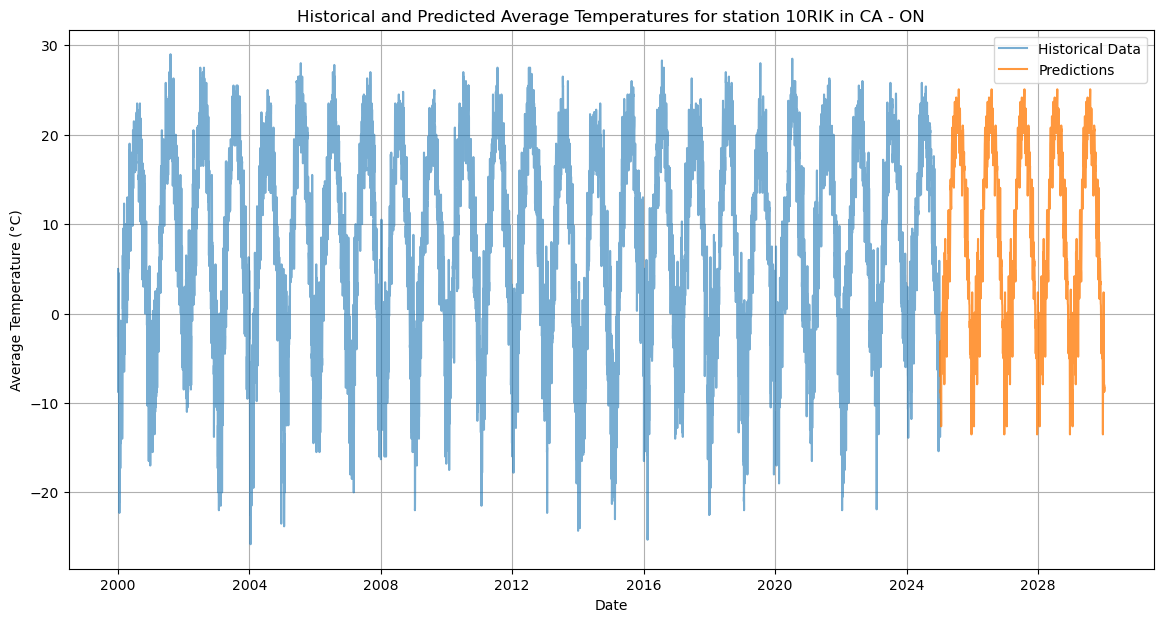

Predictions saved to 'predicted_temperatures.csv'


In [123]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import matplotlib.pyplot as plt

# Prepare Features
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].dt.dayofyear
#df['year'] = df['date'].dt.year

# Features: Day of the year and year; Target: Average temperature
X = df[['day_of_year', 'year']]
y = df['avg_temp']

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Step 6: Evaluate Model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}°C")

# Step 7: Predict for Next 5 Years
future_years = pd.date_range(start=df['date'].max() + timedelta(days=1), 
                             periods=5 * 365, freq='D')
future_df = pd.DataFrame({
    'date': future_years,
    'day_of_year': future_years.day_of_year,
    'year': future_years.year
})
future_predictions = model.predict(future_df[['day_of_year', 'year']])
future_df['predicted_tavg'] = future_predictions

# Step 8: Plot Known Data and Predictions
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(df['date'], df['avg_temp'], label='Historical Data', alpha=0.6)

# Plot predictions
plt.plot(future_df['date'], future_df['predicted_tavg'], label='Predictions', alpha=0.8)

plt.title(f'Historical and Predicted Average Temperatures for station {chosenstation} in {chosencountry} - {chosenregion}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

# Step 9: Save Predictions
future_df.to_csv('predicted_temperatures.csv', index=False)
print(f"Predictions saved to 'predicted_temperatures.csv'")

# Sci Kit Learn
https://www.askpython.com/python/examples/weather-data-clustering

In [136]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
                
        # Execute the SQL query
        query =f"SELECT id, date, avg_temp, min_temp, max_temp, month, year FROM `{table_name}` WHERE station_id = %s"
        cursor.execute(query, (chosenstation,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df= pd.DataFrame(rows)
        df.columns=['id', 'date', 'avg_temp', 'min_temp', 'max_temp','month', 'year']
        
        # Print the first 5 rows
        print(df.head(5))

except msql.Error as err: 
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

        id        date avg_temp min_temp max_temp  month  year
0  10RIK_0  2000-01-01     -2.5    -11.0      6.0      1  2000
1  10RIK_1  2000-01-02      5.0     -2.0     12.0      1  2000
2  10RIK_2  2000-01-03     -0.3     -2.0      1.5      1  2000
3  10RIK_3  2000-01-04      4.5     -2.0     11.0      1  2000
4  10RIK_4  2000-01-05     -8.8    -11.5     -6.0      1  2000


https://www.askpython.com/python/examples/weather-data-clustering

c:\Users\kirst\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


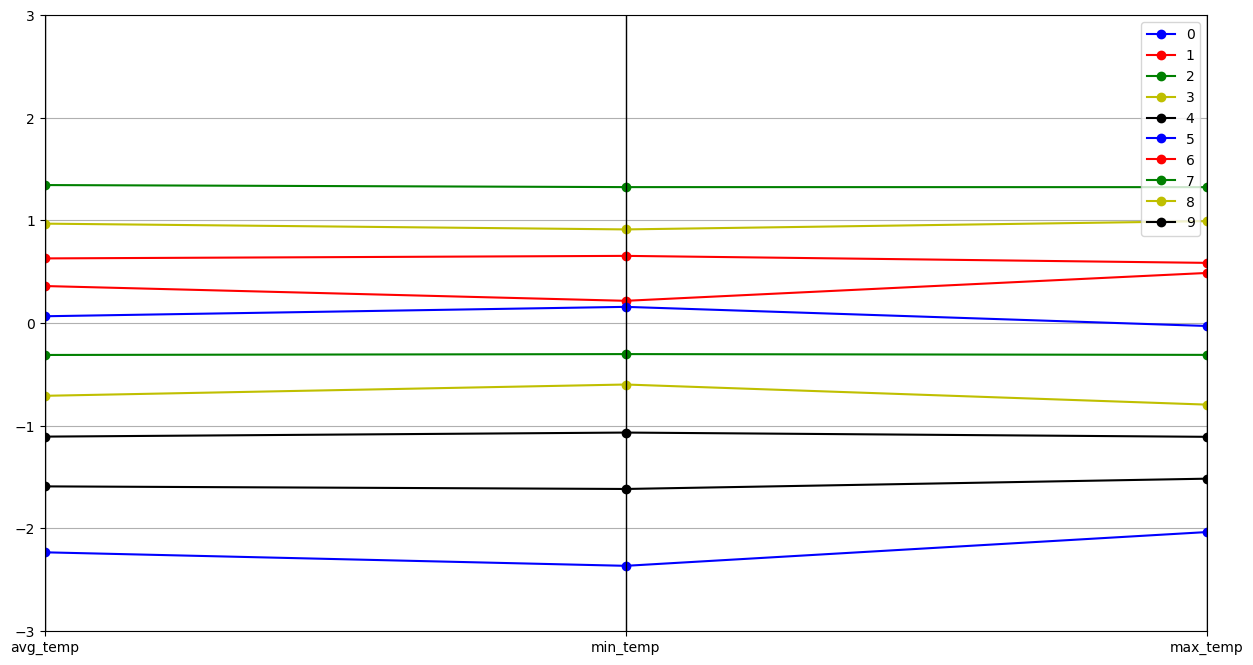

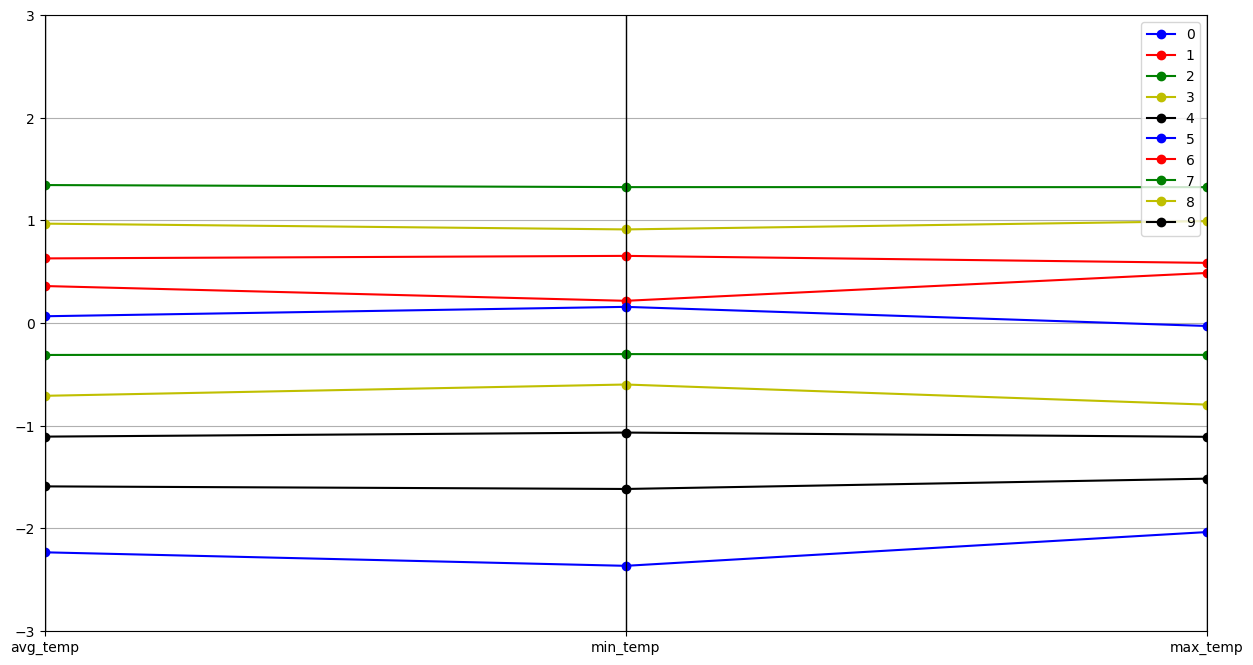

In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

# Select every 10th row for faster processing

df.dropna(inplace=True)
sampled_df = df.iloc[::10]
sampled_df.shape

# Select features for clustering
features = ['avg_temp', 'min_temp', 'max_temp']
selected_df = sampled_df[features]

# Standardize the features
X = StandardScaler().fit_transform(selected_df)

# Apply KMenas clustering
KM = KMeans(n_clusters=10)
model = KM.fit(X)
centers = model.cluster_centers_

# Visualize the clusters

# 1. Function that generates a DataFrame with a Cluster Number column.
 
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
 
# 2. Function that creates Parallel Plots
 
def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
 
P = pd_centers(features, centers)

parallel_plot(P[P['min_temp'] < lettuce_range1])
parallel_plot(P[P['avg_temp'] < lettuce_range1])

## Thermal curtains

The data in the below has been changed to help protect the intellectual property. Many plant crops scorch and reduce their efficiency at temperatures over 23 degrees and the traditional approach has been to whitewash growhouses. Unfortunately, this white washing is not easily removed, so whitewashes are applied at the beginning of the summer and washed off at the end, this means if there is a run of poor weather in summer the plants can't be productive and if there is good weather outside of summer the plants scorch. 

   year  month  total_hot_days  hot_near_cold_days
0  2000      1               0                   0
1  2000      2               0                   0
2  2000      3               0                   0
3  2000      4               1                   1
4  2000      5               9                   9


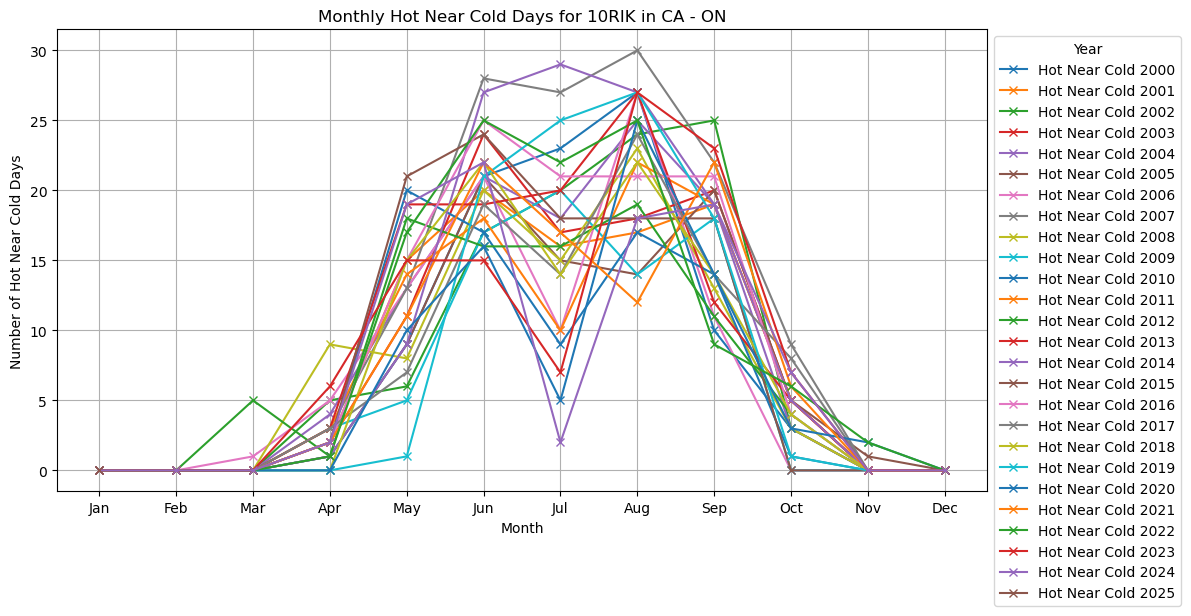

In [147]:
# Highlight data for days with maximimum temperature over the optimum for lettuce > 23 degrees and proximity to minimum temperature below the optimum for lettuce

# Identify hot days
df["hot_days"] = df["max_temp"] > lettuce_range2

# Identify cold days
df["cold_days"] = df["min_temp"] < lettuce_range1

# Identify hot days near cold days
df["cold_within_5"] = df["cold_days"].rolling(window=5, min_periods=1).max().shift(-4).fillna(0).astype(bool)

df["hot_near_cold"] = df["hot_days"] & df["cold_within_5"]

# Group by both year and month to count hot days and hot days near cold days
highlight_summary = df.groupby(["year", "month"]).agg(
    total_hot_days=("hot_days", "sum"),
    hot_near_cold_days=("hot_near_cold", "sum")
).reset_index()

# Print summary to verify
print(highlight_summary.head())

# Plot hot days and hot days near cold days
plt.figure(figsize=(12, 6))
for year in highlight_summary["year"].unique():
    year_data = highlight_summary[highlight_summary["year"] == year]
    #plt.plot(year_data["month"], year_data["total_hot_days"], marker="o", label=f"Hot Days {year}")
    plt.plot(year_data["month"], year_data["hot_near_cold_days"], marker="x", label=f"Hot Near Cold {year}")

plt.title(f"Monthly Hot Near Cold Days for {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Number of Hot Near Cold Days")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

[(1)]https://dev.meteostat.net/
[(2)] https://content.ces.ncsu.edu/lettuce
[(3)] https://drygair.com/blog/what-are-the-ideal-conditions-for-greenhouse-tomatoes/
https://www.askpython.com/python/examples/weather-data-clustering

https://esciencecenter-digital-skills.github.io/lesson-machine-learning-intro/02-data-exploration.html